# Read Files

In [146]:
import pandas as pd
import os
import importlib
import clean_gene_name  # import the module first
importlib.reload(clean_gene_name)  # reload the module
from clean_gene_name import clean_gene_name  # re-import the updated function

# Load expression_df
path = ('/Users/atanugiri/.cache/kagglehub/datasets/mahdiehhajian/'
'gene-expression-in-gastric-cancer/versions/1')

# Full file path
file_path = os.path.join(path, 'expression profile(8863 genes).csv')

# Read the CSV and set first column as index
expression_df = pd.read_csv(file_path, index_col=0)

# Preview
print(expression_df.head(2))
print(expression_df.shape)


# Load clinical_df
file_path = 'tcga_gdc_clinical_data.tsv'
columns_to_use = ['Sample ID', 'Diagnosis Age', 'Disease Free (Months)', 
                 'Disease Free Status', 'Fraction Genome Altered', 'ICD-10 Classification',
                 'Mutation Count', 'Overall Survival (Months)', 'Overall Survival Status',
                 'AJCC Pathologic M-Stage', 'AJCC Pathologic N-Stage', 'AJCC Pathologic Stage',
                 'AJCC Pathologic T-Stage', 'Race Category', 'Sex']
# Read the file with tab separator and selected columns
clinical_df = pd.read_csv(file_path, sep='\t', usecols=columns_to_use)

## Convert status to numeric
status_map = {'0:LIVING': 0, '1:DECEASED': 1}
clinical_df["Overall Survival Status"] = clinical_df["Overall Survival Status"].map(status_map)

# Preview the data
print(clinical_df.head(n=2))
print(clinical_df.shape)

       TCGA-BR-4279-01  TCGA-VQ-A94T-01  TCGA-BR-8589-01  TCGA-BR-A4IV-01  \
A1CF           10.4647           6.6146          10.4016           4.6554   
A2ML1           0.0000           4.3985           2.4817           1.3475   

       TCGA-VQ-A8E2-01  TCGA-BR-8297-01  TCGA-D7-A4YY-01  TCGA-BR-4280-01  \
A1CF            9.8054           4.7419           5.1548          10.5675   
A2ML1           3.4159           2.4948           6.3345           0.0000   

       TCGA-D7-A74A-01  TCGA-F1-6177-01  ...  GTEX-QV44-1226-SM-4R1KE  \
A1CF            9.4567          10.7863  ...                   5.7464   
A2ML1           6.7217           0.0000  ...                   3.5820   

       GTEX-13PVQ-2126-SM-5L3FW  GTEX-SNMC-0626-SM-4DM6H  \
A1CF                     3.5094                   5.3059   
A2ML1                    3.3348                   4.4367   

       GTEX-WZTO-2126-SM-4PQYW  GTEX-Q2AH-1126-SM-48TZM  \
A1CF                    3.2506                   5.4593   
A2ML1            

In [147]:
# Step 1: Clean and align patient IDs
expression_df.columns = expression_df.columns.str.strip().str.upper()
clinical_df["Sample ID"] = clinical_df["Sample ID"].str.strip().str.upper()

# Step 2: Find common samples
common_samples = expression_df.columns.intersection(clinical_df["Sample ID"])
print(common_samples)
print(len(common_samples))

# Step 3: Subset both datasets to common patients
expression_df = expression_df[common_samples]
clinical_df = clinical_df[clinical_df["Sample ID"].isin(common_samples)]

# Step 4: Reorder clinical_df to match column order of expression_df
clinical_df = clinical_df.set_index("Sample ID").loc[common_samples].reset_index()

# Step 5: Rename "index" back to "Sample ID"
clinical_df.rename(columns={"index": "Sample ID"}, inplace=True)

print(f"expression_df shape: {expression_df.shape}")
print(f"expression_df shape: {clinical_df.shape}")

Index(['TCGA-BR-4279-01', 'TCGA-VQ-A94T-01', 'TCGA-BR-8589-01',
       'TCGA-BR-A4IV-01', 'TCGA-VQ-A8E2-01', 'TCGA-BR-8297-01',
       'TCGA-D7-A4YY-01', 'TCGA-BR-4280-01', 'TCGA-D7-A74A-01',
       'TCGA-F1-6177-01',
       ...
       'TCGA-VQ-A92D-01', 'TCGA-HU-A4H0-01', 'TCGA-RD-A7BW-01',
       'TCGA-BR-8686-01', 'TCGA-BR-4256-01', 'TCGA-D7-8576-01',
       'TCGA-VQ-A8DT-01', 'TCGA-BR-4363-01', 'TCGA-CD-A486-01',
       'TCGA-HU-A4G6-01'],
      dtype='object', length=413)
413
expression_df shape: (8863, 413)
expression_df shape: (413, 15)


In [148]:
assert all(expression_df.columns == clinical_df["Sample ID"])
print("Expression data and clinical metadata are aligned!")

Expression data and clinical metadata are aligned!


## Order genes by expression

In [149]:
gene_variance = expression_df.var(axis=1).sort_values(ascending=False)
top_genes = gene_variance.head(20).index
top_genes

Index(['LIPF', 'PGA3', 'XIST', 'GKN1', 'PGA4', 'RPS4Y1', 'MAGEA3', 'PGC',
       'DAZ1', 'MAGEA6', 'BPIFB1', 'DDX3Y', 'GKN2', 'OLFM4', 'KDM5D',
       'RP11-205M5.3', 'MUC5AC', 'CTD-2369P2.12', 'MUC6', 'FABP1'],
      dtype='object')

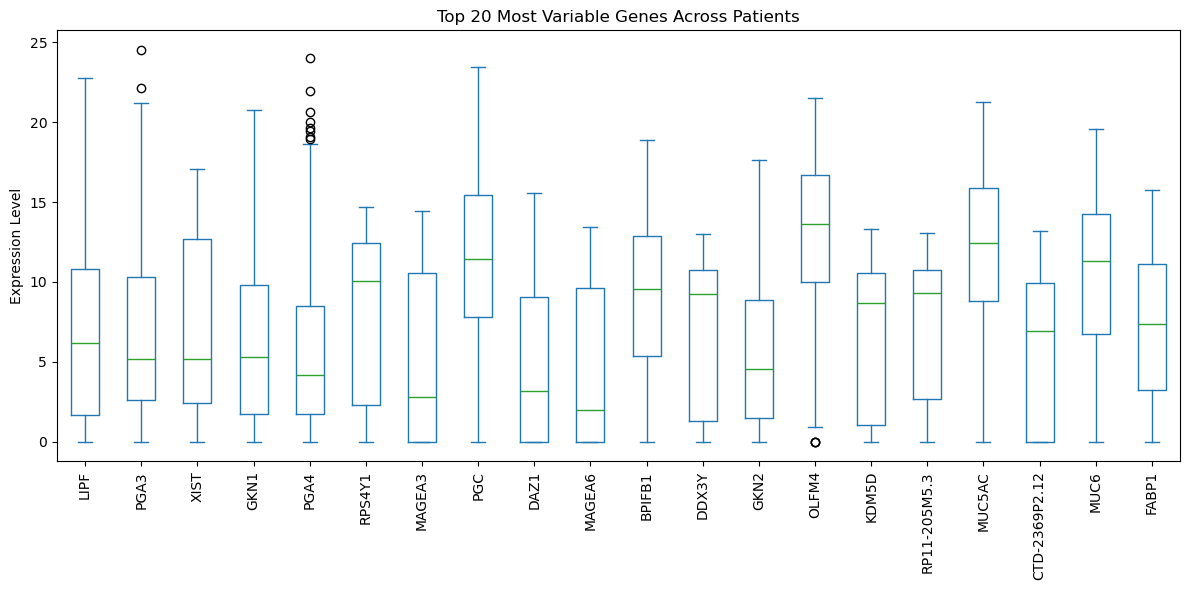

In [150]:
import matplotlib.pyplot as plt

# Transpose to shape: (patients, genes)
expression_df.loc[top_genes].T.plot(kind='box', figsize=(12, 6))

plt.title("Top 20 Most Variable Genes Across Patients")
plt.ylabel("Expression Level")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### CD36 rank by expression

In [151]:
# Get variance ranking of CD36
cd36_variance = expression_df.var(axis=1).loc["CD36"]
rank = expression_df.var(axis=1).rank(ascending=False).loc["CD36"]
print(f"CD36 variance: {cd36_variance:.4f}, Rank: {int(rank)} out of {expression_df.shape[0]}")

CD36 variance: 2.3162, Rank: 3870 out of 8863


## Survival status analysis

### CD36 expression by survival status

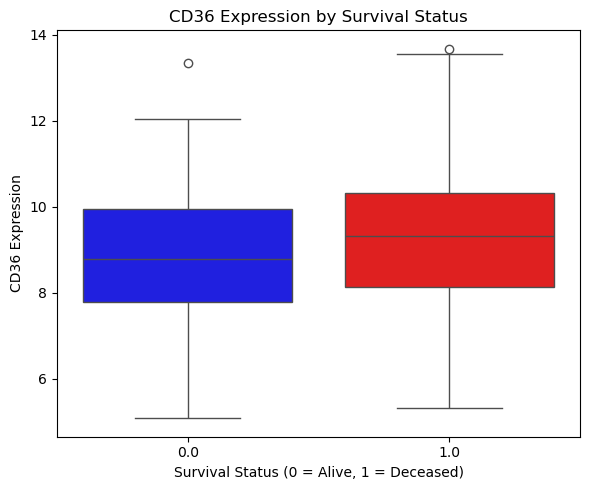

Figure saved as 'CD36_expression_by_survival.png'


In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correct palette with float keys
palette = {0.0: "blue", 1.0: "red"}

plt.figure(figsize=(6, 5))
sns.boxplot(
    x="Overall Survival Status",
    y="CD36 Expression",
    hue="Overall Survival Status",  # required for palette use
    data=plot_df,
    palette=palette,
    dodge=False,
    legend=False  # avoid duplicate legend
)

plt.xlabel("Survival Status (0 = Alive, 1 = Deceased)")
plt.ylabel("CD36 Expression")
plt.title("CD36 Expression by Survival Status")
plt.tight_layout()
plt.savefig("CD36_expression_by_survival.png", dpi=300)
plt.show()

print("Figure saved as 'CD36_expression_by_survival.png'")

In [153]:
from scipy.stats import ttest_ind

alive_vals = plot_df[plot_df["Overall Survival Status"] == 0]["CD36 Expression"]
dead_vals = plot_df[plot_df["Overall Survival Status"] == 1]["CD36 Expression"]

t_stat, p_val = ttest_ind(alive_vals, dead_vals, equal_var=False)
print(f"CD36 Expression: t = {t_stat:.3f}, p = {p_val:.4f}")

CD36 Expression: t = -2.743, p = 0.0064


## Survival months analysis 

Split into High vs. Low Expression

In [154]:
# Calculate median expression
threshold = expression_df.loc["CD36"].median()

# Add group label to clinical_df
clinical_df["CD36_Group"] = [
    "High" if val >= threshold else "Low" 
    for val in expression_df.loc["CD36"]
]

Visualize Survival Months by CD36 Group

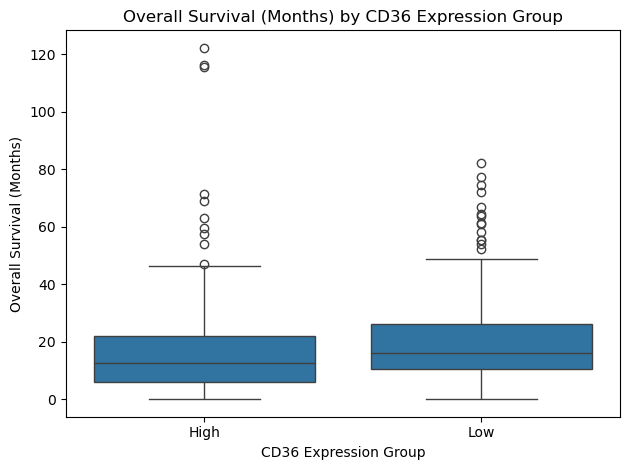

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x="CD36_Group", y="Overall Survival (Months)", data=clinical_df)
plt.title("Overall Survival (Months) by CD36 Expression Group")
plt.ylabel("Overall Survival (Months)")
plt.xlabel("CD36 Expression Group")
plt.tight_layout()
plt.show()

Statistical Test: t-test Between Groups

In [156]:
from scipy.stats import ttest_ind

group_high = clinical_df[clinical_df["CD36_Group"] == "High"]["Overall Survival (Months)"]
group_low = clinical_df[clinical_df["CD36_Group"] == "Low"]["Overall Survival (Months)"]

# Drop NaNs
group_high = group_high.dropna()
group_low = group_low.dropna()

t_stat, p_val = ttest_ind(group_high, group_low, equal_var=False)
print(f"Survival comparison by CD36: t = {t_stat:.3f}, p = {p_val:.4f}")

Survival comparison by CD36: t = -1.684, p = 0.0929


### KM survival curve by CD36 expression

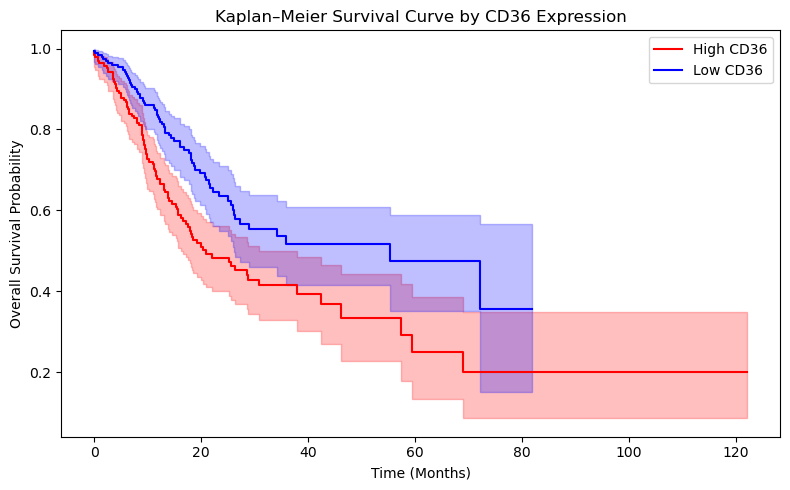

Saved: KM_CD36_survival_curve.png


In [157]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Prepare data
km_df = clinical_df[["Overall Survival (Months)", "Overall Survival Status", "CD36_Group"]].dropna()

# Initialize KM fitter
kmf = KaplanMeierFitter()

# Set group-specific colors
group_colors = {"High": "red", "Low": "blue"}

# Plot
plt.figure(figsize=(8, 5))

for group in ["High", "Low"]:
    mask = km_df["CD36_Group"] == group
    kmf.fit(
        durations=km_df[mask]["Overall Survival (Months)"],
        event_observed=km_df[mask]["Overall Survival Status"],
        label=f"{group} CD36"
    )
    kmf.plot_survival_function(ci_show=True, color=group_colors[group])

plt.title("Kaplan–Meier Survival Curve by CD36 Expression")
plt.xlabel("Time (Months)")
plt.ylabel("Overall Survival Probability")
plt.tight_layout()

# Save the figure
plt.savefig("KM_CD36_survival_curve.png", dpi=300)
plt.show()

print("Saved: KM_CD36_survival_curve.png")

In [158]:
from lifelines.statistics import logrank_test

# Groups
high = km_df[km_df["CD36_Group"] == "High"]
low = km_df[km_df["CD36_Group"] == "Low"]

# Test
results = logrank_test(
    high["Overall Survival (Months)"], low["Overall Survival (Months)"],
    event_observed_A=high["Overall Survival Status"],
    event_observed_B=low["Overall Survival Status"]
)

print(f"Log-rank test: p = {results.p_value:.4f}")

Log-rank test: p = 0.0009


## Sex effect study

### Compare CD36 Expression Between Male and Female

/var/folders/_n/c65sg0c951g6vgwcpzsdc2tc0000gn/T/ipykernel_84682/1220157197.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


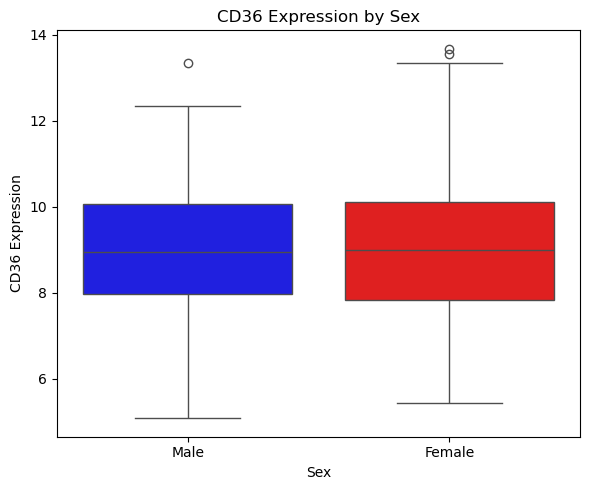

Saved as 'CD36_expression_by_sex.png'


In [180]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom color palette for Sex
sex_palette = {"Male": "blue", "Female": "red"}

# Prepare the plot
plt.figure(figsize=(6, 5))
sns.boxplot(
    x="Sex",
    y="CD36 Expression",
    data=plot_df,
    palette=sex_palette
)

plt.title("CD36 Expression by Sex")
plt.tight_layout()

# Save the figure
plt.savefig("CD36_expression_by_sex.png", dpi=300)
plt.show()

print("Saved as 'CD36_expression_by_sex.png'")

In [160]:
from scipy.stats import ttest_ind

male_vals = plot_df[plot_df["Sex"] == "Male"]["CD36 Expression"]
female_vals = plot_df[plot_df["Sex"] == "Female"]["CD36 Expression"]

t_stat, p_val = ttest_ind(male_vals, female_vals, equal_var=False)
print(f"CD36 Expression by Sex: t = {t_stat:.3f}, p = {p_val:.4f}")


CD36 Expression by Sex: t = 0.035, p = 0.9723


### Compare Survival Months by Sex

/var/folders/_n/c65sg0c951g6vgwcpzsdc2tc0000gn/T/ipykernel_84682/3393799687.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


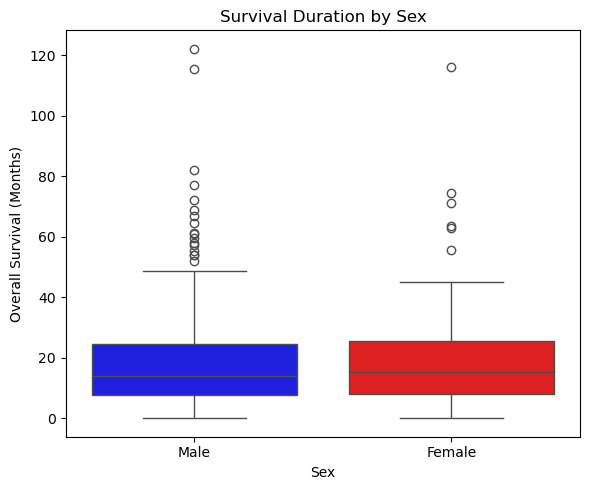

Survival by Sex: t = 0.335, p = 0.7379


In [179]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Define custom color palette
sex_palette = {"Male": "blue", "Female": "red"}

# Plot
plt.figure(figsize=(6, 5))
sns.boxplot(
    x="Sex",
    y="Overall Survival (Months)",
    data=clinical_df,
    palette=sex_palette
)

plt.title("Survival Duration by Sex")
plt.tight_layout()

# Save the figure
plt.savefig("survival_by_sex.png", dpi=300)
plt.show()

# T-test
male_surv = clinical_df[clinical_df["Sex"] == "Male"]["Overall Survival (Months)"].dropna()
female_surv = clinical_df[clinical_df["Sex"] == "Female"]["Overall Survival (Months)"].dropna()

t_stat, p_val = ttest_ind(male_surv, female_surv, equal_var=False)
print(f"Survival by Sex: t = {t_stat:.3f}, p = {p_val:.4f}")


## Race effect study

In [162]:
print(clinical_df["Race Category"].value_counts(dropna=False))

Race Category
WHITE                                        259
ASIAN                                         86
NaN                                           55
BLACK OR AFRICAN AMERICAN                     12
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER      1
Name: count, dtype: int64


### Boxplot of CD36 Expression by Race

In [163]:
# Define races to include
selected_races = ["WHITE", "ASIAN", "BLACK OR AFRICAN AMERICAN"]

# Filter clinical data
filtered_race_df = clinical_df[clinical_df["Race Category"].isin(selected_races)].copy()

# Add CD36 expression
filtered_race_df["CD36 Expression"] = expression_df.loc["CD36", filtered_race_df["Sample ID"]].values


/var/folders/_n/c65sg0c951g6vgwcpzsdc2tc0000gn/T/ipykernel_84682/2116700434.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


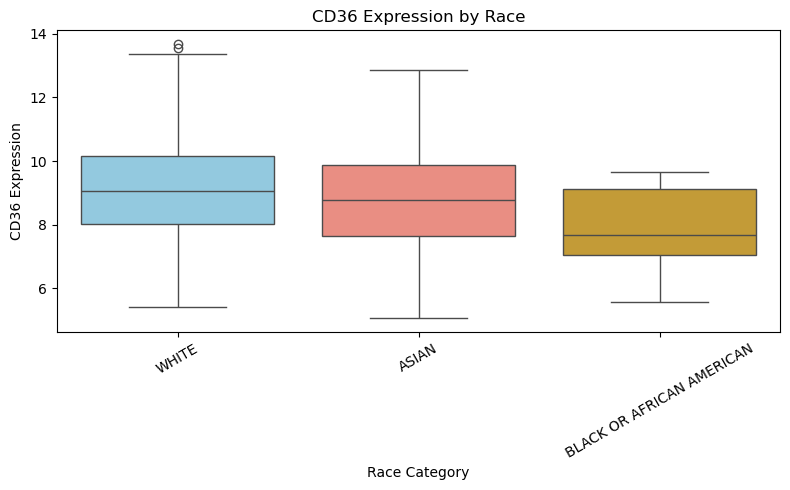

Saved as 'CD36_expression_by_race.png'


In [164]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom colors for each race category
custom_palette = {
    "WHITE": "skyblue",
    "ASIAN": "salmon",
    "BLACK OR AFRICAN AMERICAN": "goldenrod"
}

plt.figure(figsize=(8, 5))
sns.boxplot(
    x="Race Category",
    y="CD36 Expression",
    data=filtered_race_df,
    palette=custom_palette
)

plt.title("CD36 Expression by Race")
plt.xticks(rotation=30)
plt.tight_layout()

# Save the figure
plt.savefig("CD36_expression_by_race.png", dpi=300)
plt.show()

print("Saved as 'CD36_expression_by_race.png'")


In [165]:
from scipy.stats import f_oneway

# Extract values per group
groups = [
    filtered_race_df[filtered_race_df["Race Category"] == race]["CD36 Expression"].dropna()
    for race in selected_races
]

f_stat, p_val = f_oneway(*groups)
print(f"ANOVA: CD36 by Race (WHITE, ASIAN, BLACK): F = {f_stat:.3f}, p = {p_val:.4f}")


ANOVA: CD36 by Race (WHITE, ASIAN, BLACK): F = 4.998, p = 0.0072


## Analysis of cancer type

In [166]:
cancer_stage = clinical_df["AJCC Pathologic Stage"]
print(cancer_stage.value_counts(dropna=False))

AJCC Pathologic Stage
Stage IIIA    71
Stage IIIB    57
Stage IIB     55
Stage IV      41
Stage IB      40
Stage IIIC    37
Stage IIA     37
Stage II      29
NaN           25
Stage IA      16
Stage III      3
Stage I        2
Name: count, dtype: int64


In [167]:
# Extract Roman numeral (I, II, III, IV)
clinical_df["Stage Group"] = (
    clinical_df["AJCC Pathologic Stage"]
    .str.extract(r"(Stage\s+I{1,3}V?)")[0]
)

In [168]:
print(clinical_df["Stage Group"].value_counts(dropna=False))

Stage Group
Stage III    168
Stage II     121
Stage I       58
Stage IV      41
NaN           25
Name: count, dtype: int64


In [169]:
# Define desired stage order
stage_order = ["Stage I", "Stage II", "Stage III", "Stage IV"]

# Convert to ordered category
clinical_df["Stage Group"] = pd.Categorical(
    clinical_df["Stage Group"],
    categories=stage_order,
    ordered=True
)

/var/folders/_n/c65sg0c951g6vgwcpzsdc2tc0000gn/T/ipykernel_84682/2662630446.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


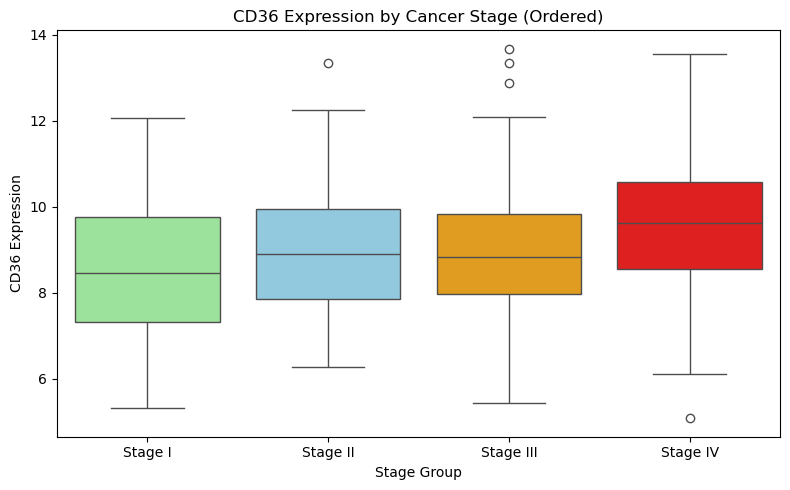

Saved: CD36_expression_by_stage.png


In [170]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette for the 4 stages
stage_palette = {
    "Stage I": "lightgreen",
    "Stage II": "skyblue",
    "Stage III": "orange",
    "Stage IV": "red"
}

# Prepare data
stage_plot_df = clinical_df[clinical_df["Stage Group"].notna()].copy()
stage_plot_df["CD36 Expression"] = expression_df.loc["CD36", stage_plot_df["Sample ID"]].values

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(
    x="Stage Group",
    y="CD36 Expression",
    data=stage_plot_df,
    palette=stage_palette
)

plt.title("CD36 Expression by Cancer Stage (Ordered)")
plt.tight_layout()

# Save the figure
plt.savefig("CD36_expression_by_stage.png", dpi=300)
plt.show()

print("Saved: CD36_expression_by_stage.png")

In [171]:
from scipy.stats import f_oneway

groups = [
    stage_plot_df[stage_plot_df["Stage Group"] == stage]["CD36 Expression"]
    for stage in sorted(stage_plot_df["Stage Group"].unique())
]

f_stat, p_val = f_oneway(*groups)
print(f"ANOVA: CD36 by Stage Group: F = {f_stat:.3f}, p = {p_val:.4f}")

ANOVA: CD36 by Stage Group: F = 3.477, p = 0.0161


# Volcano Plot

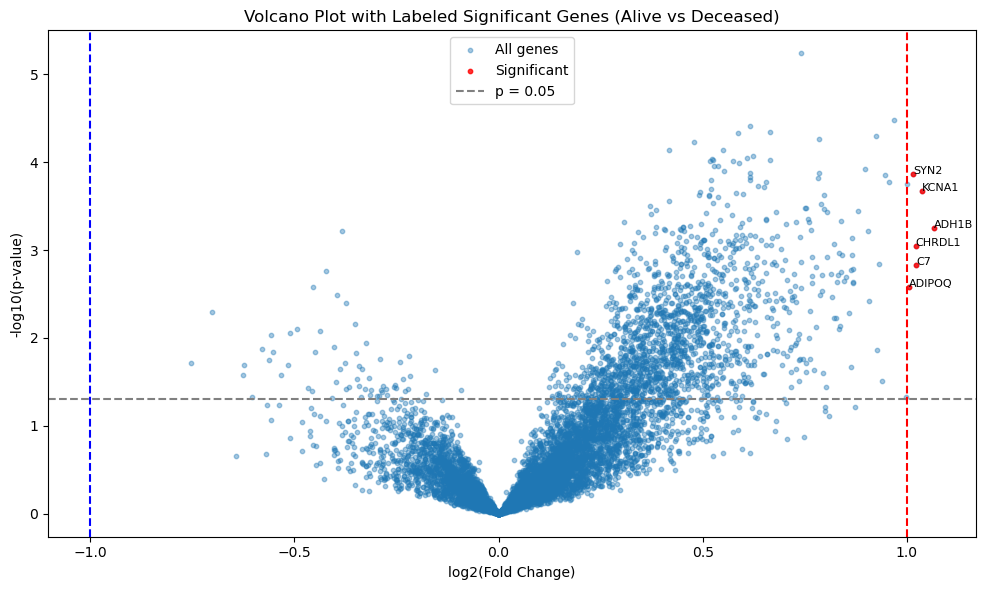

✅ Saved: volcano_plot_labeled_significant.png


In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Create arrays
log2_fc = []
pvals = []

alive_ids = clinical_df[clinical_df["Overall Survival Status"] == 0]["Sample ID"]
dead_ids = clinical_df[clinical_df["Overall Survival Status"] == 1]["Sample ID"]

for gene in expression_df.index:
    group1 = expression_df.loc[gene, alive_ids]
    group2 = expression_df.loc[gene, dead_ids]
    
    # Log2 fold change (group2 - group1)
    fc = group2.mean() - group1.mean()
    log2_fc.append(fc)
    
    # t-test
    _, p = ttest_ind(group1, group2, equal_var=False, nan_policy='omit')
    pvals.append(p)

# Create DataFrame
volcano_df = pd.DataFrame({
    "Gene": expression_df.index,
    "log2FC": log2_fc,
    "pval": pvals
})
volcano_df["-log10pval"] = -np.log10(volcano_df["pval"])

# Filter for significant genes
significant_genes = volcano_df[
    (volcano_df["pval"] < 0.05) & (abs(volcano_df["log2FC"]) >= 1)
]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(volcano_df["log2FC"], volcano_df["-log10pval"], s=10, alpha=0.4, label='All genes')
plt.scatter(significant_genes["log2FC"], significant_genes["-log10pval"], color='red', s=10, alpha=0.8, label='Significant')

# Label significant genes
for _, row in significant_genes.iterrows():
    plt.text(row["log2FC"], row["-log10pval"], row["Gene"],
             fontsize=8, ha='right' if row["log2FC"] < 0 else 'left')

# Threshold lines
plt.axhline(-np.log10(0.05), linestyle='--', color='gray', label='p = 0.05')
plt.axvline(1, linestyle='--', color='red')
plt.axvline(-1, linestyle='--', color='blue')

plt.xlabel("log2(Fold Change)")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot with Labeled Significant Genes (Alive vs Deceased)")
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig("volcano_plot_labeled_significant.png", dpi=300)
plt.show()

print("Saved: volcano_plot_labeled_significant.png")


## Volcano plot with FDR

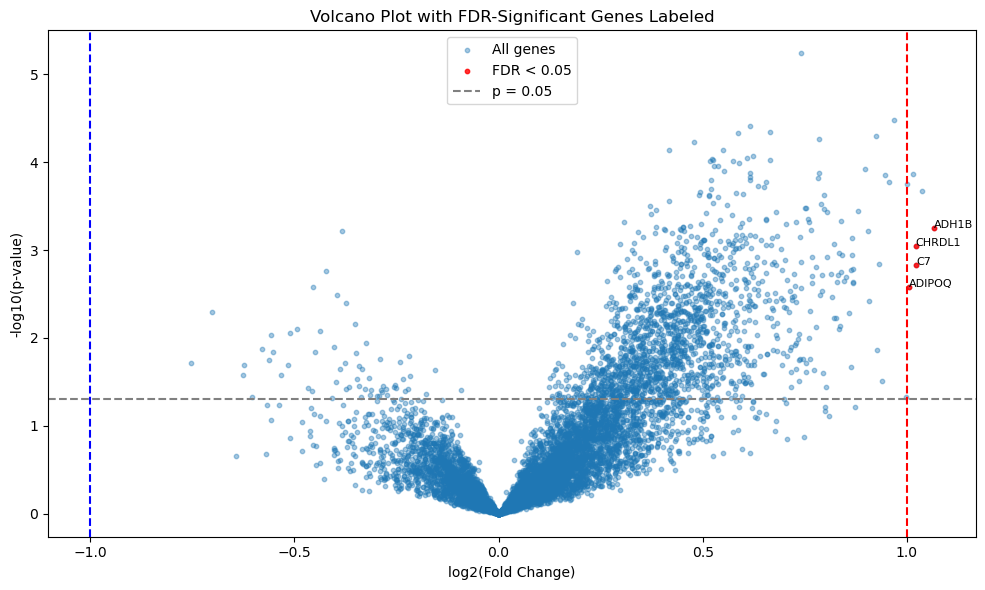

Saved: volcano_plot_fdr_labeled.png


In [178]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# All genes
plt.scatter(volcano_df["log2FC"], -np.log10(volcano_df["pval"]), s=10, alpha=0.4, label='All genes')

# FDR-significant genes
plt.scatter(significant_fdr["log2FC"], -np.log10(significant_fdr["pval"]),
            color='red', s=10, alpha=0.8, label='FDR < 0.05')

# Label genes
for _, row in significant_fdr.iterrows():
    plt.text(
        row["log2FC"],
        -np.log10(row["pval"]),
        row["Gene"],
        fontsize=8,
        ha='right' if row["log2FC"] < 0 else 'left'
    )

# Threshold lines
plt.axhline(-np.log10(0.05), linestyle='--', color='gray', label='p = 0.05')
plt.axvline(1, linestyle='--', color='red')
plt.axvline(-1, linestyle='--', color='blue')

plt.xlabel("log2(Fold Change)")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot with FDR-Significant Genes Labeled")
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig("volcano_plot_fdr_labeled.png", dpi=300)
plt.show()

print("Saved: volcano_plot_fdr_labeled.png")
